In [48]:
import pandas as pd
import numpy as np
import re
import random

# --- PHASE 1 LOGIC (Updated with "Last Stand" check) ---
def process_dwts_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    
    # Identify score columns
    week_cols = [c for c in df.columns if c.startswith('week') and 'judge1' in c]
    all_week_nums = sorted(list(set([int(c.split('_')[0].replace('week', '')) for c in week_cols])))
    
    # Pre-calculate Season Finales
    season_finales = {}
    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        max_w = 0
        for w in all_week_nums:
            col = f'week{w}_judge1_score'
            if col in df.columns and season_df[col].sum() > 0:
                max_w = w
        season_finales[season] = max_w

    # Pre-calculate Each Contestant's "Last Stand"
    contestant_last_week = {}
    for idx, row in df.iterrows():
        c_name = row['celebrity_name']
        s_num = row['season']
        last_w = 0
        for w in all_week_nums:
            col = f'week{w}_judge1_score'
            if col in df.columns and row[col] > 0:
                last_w = w
        contestant_last_week[(s_num, c_name)] = last_w

    weekly_results = []

    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        final_week = season_finales[season]
        
        for w in all_week_nums:
            if w > final_week: continue
            
            score_col = f'week{w}_judge1_score'
            if score_col not in df.columns: continue
            
            active_dancers = season_df[season_df[score_col] > 0].copy()
            if active_dancers.empty: continue

            # Calc Judge Stats
            judge_cols = [c for c in df.columns if c.startswith(f'week{w}_judge')]
            active_dancers['weekly_judge_total'] = active_dancers[judge_cols].sum(axis=1)
            # Rank (Higher Score = Rank 1)
            active_dancers['judge_rank'] = active_dancers['weekly_judge_total'].rank(ascending=False, method='average')

            # Status Logic
            def determine_status(row):
                c_name = row['celebrity_name']
                s_num = row['season']
                result_str = str(row['results'])
                my_last_week = contestant_last_week.get((s_num, c_name), 0)

                if "Withdrew" in result_str: return "Safe"
                if w < my_last_week: return "Safe"
                if w == my_last_week:
                    if w == final_week:
                        place_match = re.search(r'(\d+)[a-z]{2} Place', result_str)
                        if place_match: return int(place_match.group(1))
                        return "Safe"
                    else:
                        return "Eliminated"
                return "Safe"

            active_dancers['calculated_status'] = active_dancers.apply(determine_status, axis=1)
            
            for _, row in active_dancers.iterrows():
                weekly_results.append({
                    'Season': season,
                    'Week': w,
                    'Contestant': row['celebrity_name'],
                    'Judge_Total': row['weekly_judge_total'],
                    'Judge_Rank': row['judge_rank'],
                    'Status': row['calculated_status'],
                    'Original_Result': row['results']
                })

    return pd.DataFrame(weekly_results)

In [49]:
# --- PHASE 2 LOGIC (Monte Carlo) ---
def solve_fan_ranks_monte_carlo(df_state, simulations=5000): # Lowered sims slightly for speed in this environment
    results_store = {}
    groups = df_state.groupby(['Season', 'Week'])
    
    for (season, week), group in groups:
        contestants = group['Contestant'].tolist()
        judge_ranks = group['Judge_Rank'].values
        statuses = group['Status'].values
        n = len(contestants)
        
        # Skip if no info gained (no eliminations or placements)
        if "Eliminated" not in statuses and not any(isinstance(s, (int, float)) for s in statuses):
            continue

        week_counts = {c: np.zeros(n) for c in contestants}
        valid_scenarios = 0
        rank_indices = np.arange(1, n + 1)
        
        for _ in range(simulations):
            np.random.shuffle(rank_indices)
            fan_ranks = rank_indices
            total_scores = judge_ranks + fan_ranks
            is_valid = False
            
            # Logic Branch
            # Seasons 1, 2, 28-34 are handled differently
            # The prompt implies Rank Based for 1, 2, and 28+. 
            # BUT the prompt says 28+ uses "Bottom 2 + Judges Save".
            # The code I wrote previously handled this.
            
            if season <= 2: # Pure Rank Sum (Eliminated = Worst Score)
                elim_indices = [i for i, s in enumerate(statuses) if s == "Eliminated"]
                if not elim_indices:
                    # Finale check (Winner < Runner Up)
                    # Simplified: Just assume valid if no elim (e.g. finale placements)
                    # Or implement specific ordering check.
                    # For simplicity, if no 'Eliminated' status, we might skip or treat loosely.
                    # Let's check placements if present
                    if any(isinstance(s, (int, float)) for s in statuses):
                        # Extract placements
                        placements = [(i, s) for i, s in enumerate(statuses) if isinstance(s, (int, float))]
                        # Sort by placement (1, 2, 3)
                        placements.sort(key=lambda x: x[1])
                        # Check scores: Rank 1 Score <= Rank 2 Score <= Rank 3 Score
                        valid_order = True
                        for k in range(len(placements)-1):
                            idx_a = placements[k][0]
                            idx_b = placements[k+1][0]
                            if total_scores[idx_a] > total_scores[idx_b]: # Lower score is better
                                valid_order = False
                                break
                        if valid_order: is_valid = True
                else:
                    elim_idx = elim_indices[0]
                    survivor_mask = [s != "Eliminated" for s in statuses]
                    if any(survivor_mask):
                        max_survivor_score = np.max(total_scores[survivor_mask])
                        # Eliminated person must be WORSE (Higher) or TIED with max survivor
                        if total_scores[elim_idx] >= max_survivor_score:
                            is_valid = True
            
            else: # Season 28+ (Bottom 2 + Judges Save)
                # Note: Seasons 3-27 are technically Percentage based, but dataset name implies "rank based"
                # The user prompt filtered for "rank based seasons".
                # The logic for 28+ is "Bottom 2".
                elim_indices = [i for i, s in enumerate(statuses) if s == "Eliminated"]
                if not elim_indices:
                    # Finale check
                    if any(isinstance(s, (int, float)) for s in statuses):
                        placements = [(i, s) for i, s in enumerate(statuses) if isinstance(s, (int, float))]
                        placements.sort(key=lambda x: x[1])
                        valid_order = True
                        for k in range(len(placements)-1):
                            idx_a = placements[k][0]
                            idx_b = placements[k+1][0]
                            if total_scores[idx_a] > total_scores[idx_b]:
                                valid_order = False
                                break
                        if valid_order: is_valid = True
                else:
                    elim_idx = elim_indices[0]
                    # Check if in Bottom 2 (2 Highest Scores)
                    sorted_scores = np.sort(total_scores)
                    if len(sorted_scores) >= 2:
                        bottom_threshold = sorted_scores[-2] 
                        if total_scores[elim_idx] >= bottom_threshold:
                            is_valid = True
                    else: # Only 1 person? (Shouldn't happen in elim week)
                        is_valid = True

            if is_valid:
                valid_scenarios += 1
                for i, contestant in enumerate(contestants):
                    rank_idx = fan_ranks[i] - 1
                    week_counts[contestant][rank_idx] += 1
        
        if valid_scenarios > 0:
            for contestant, counts in week_counts.items():
                probs = counts / valid_scenarios
                results_store[(season, week, contestant)] = probs

    rows = []
    for (s, w, c), probs in results_store.items():
        ranks = np.arange(1, len(probs) + 1)
        expected_rank = np.sum(ranks * probs)
        most_likely_rank = np.argmax(probs) + 1
        certainty = np.max(probs)
        
        rows.append({
            'Season': s,
            'Week': w,
            'Contestant': c,
            'Expected_Fan_Rank': expected_rank,
            'Most_Likely_Fan_Rank': most_likely_rank,
            'Model_Certainty': certainty,
            'Prob_Rank_1': probs[0] if len(probs) > 0 else 0
        })
        
    return pd.DataFrame(rows)

In [50]:
def force_distinct_ranks(df):
    """
    Converts floating point 'Expected_Fan_Rank' into distinct integers 1..N.
    Breaks ties using Judge_Rank (Worse Judge Rank = Better Fan Rank).
    """
    df_clean = df.copy()
    
    # We will compute a new column 'Distinct_Fan_Rank'
    # We apply this logic week by week
    distinct_ranks = []
    
    groups = df_clean.groupby(['Season', 'Week'])
    
    for (season, week), group in groups:
        # Create a "Sort Key" to rank them
        # 1. Primary: Expected Fan Rank (Lower is Better)
        # 2. Secondary: Judge Rank (Higher/Worse is Better for Fan Rank assumption)
        #    Why? If two people have equal model probability, the one with WORSE judge scores 
        #    needed the votes more. We give them the benefit of the doubt.
        #    We multiply Judge_Rank by -1 to sort Descending while Fan_Rank sorts Ascending.
        
        # We can use tuple sorting in a lambda
        # Sort Order: 
        #   1. Expected_Fan_Rank (Ascending) -> Real vote strength
        #   2. Judge_Rank (Descending) -> The "Underdog" tie-breaker
        
        sorted_group = group.sort_values(
            by=['Expected_Fan_Rank', 'Judge_Rank'], 
            ascending=[True, False] 
        )
        
        # Assign 1..N based on this sorted order
        sorted_group['Distinct_Fan_Rank'] = range(1, len(sorted_group) + 1)
        
        distinct_ranks.append(sorted_group)
    
    # Reassemble the dataframe
    df_final = pd.concat(distinct_ranks).sort_index()
    return df_final

In [51]:
# Load the data
file_path = 'Problem-C-dataset-rank-based.csv'
df_state = process_dwts_data(file_path)
df_fan = solve_fan_ranks_monte_carlo(df_state)

# --- MERGE ---
# We want to add Judge Scores/Ranks (from Phase 1) into the Phase 2 output.
# Left merge on Phase 2 output to keep only the solved rows, but enrich them.
df_final = pd.merge(df_fan, df_state, on=['Season', 'Week', 'Contestant'], how='left')
df_distinct = force_distinct_ranks(df_final)

# 1. Load the original data to get the metadata columns
# (Make sure to point to the correct file path)
df_original = pd.read_csv(file_path)

# Clean column names to match your pipeline
df_original.columns = df_original.columns.str.strip().str.lower()

# 2. Select the specific columns you want to add
metadata_cols = [
    'season', 
    'celebrity_name', 
    'ballroom_partner', 
    'celebrity_industry', 
    'celebrity_homestate', 
    'celebrity_homecountry/region', 
    'celebrity_age_during_season'
]

# Create a clean metadata reference table
# (We drop duplicates just in case, though the source should be unique per season/person)
df_metadata = df_original[metadata_cols].drop_duplicates()

# 3. Merge with your Final Model Results
# Assuming 'df_distinct' is your final dataframe from the previous step
df_complete = pd.merge(
    df_distinct, 
    df_metadata, 
    left_on=['Season', 'Contestant'],       # Columns in your results
    right_on=['season', 'celebrity_name'],  # Columns in the metadata
    how='left'                              # Keep all results, add info where available
)

# 4. Clean up duplicate columns (Season/season, Contestant/celebrity_name)
df_complete = df_complete.drop(columns=['season', 'celebrity_name'])

# 5. Reorder columns for a nice final report
# (Adjust this list based on what columns you actually have in df_distinct)
final_order = [
    'Season', 'Week', 'Contestant', 
    'ballroom_partner', 'celebrity_industry', 'celebrity_age_during_season', 
    'Status', 'Judge_Total', 'Judge_Rank', 
    'Expected_Fan_Rank', 'Distinct_Fan_Rank', 'Model_Certainty', 'Prob_Rank_1'
]

# Select only existing columns to avoid errors if some are missing
existing_cols = [c for c in final_order if c in df_complete.columns]
df_complete = df_complete[existing_cols]

# 6. Save or View
print(df_complete.head())
df_complete.to_csv('DWTS_Final_Model_With_Metadata.csv', index=False)

   Season  Week         Contestant     ballroom_partner celebrity_industry  \
0       1     2      John O'Hurley  Charlotte Jorgensen      Actor/Actress   
1       1     2       Kelly Monaco            Alec Mazo      Actor/Actress   
2       1     2  Evander Holyfield      Edyta Sliwinska            Athlete   
3       1     2      Rachel Hunter     Jonathan Roberts              Model   
4       1     2      Joey McIntyre      Ashly DelGrosso      Singer/Rapper   

   celebrity_age_during_season Status  Judge_Total  Judge_Rank  \
0                           50   Safe         26.0         1.0   
1                           29   Safe         17.0         5.0   
2                           42   Safe         14.0         6.0   
3                           35   Safe         24.0         2.0   
4                           32   Safe         21.0         3.0   

   Expected_Fan_Rank  Distinct_Fan_Rank  Model_Certainty  Prob_Rank_1  
0           3.507149                  4         0.188394     0

In [52]:
df_complete.head(700)

,Season,Week,Contestant,ballroom_partner,celebrity_industry,celebrity_age_during_season,Status,Judge_Total,Judge_Rank,Expected_Fan_Rank,Distinct_Fan_Rank,Model_Certainty,Prob_Rank_1
0,1,2,John O'Hurley,Charlotte Jorgensen,Actor/Actress,50,Safe,26.0000,1.0,3.507149,4,0.188394,0.156434
1,1,2,Kelly Monaco,Alec Mazo,Actor/Actress,29,Safe,17.0000,5.0,2.845248,2,0.225399,0.219512
2,1,2,Evander Holyfield,Edyta Sliwinska,Athlete,42,Safe,14.0000,6.0,2.231287,1,0.308663,0.308663
3,1,2,Rachel Hunter,Jonathan Roberts,Model,35,Safe,24.0000,2.0,3.537426,5,0.179142,0.164003
4,1,2,Joey McIntyre,Ashly DelGrosso,Singer/Rapper,32,Safe,21.0000,3.0,3.433978,3,0.202691,0.151388
...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,34,11,Elaine Hendrix,Alan Bersten (Rashad Jennings week 9),Actor/Actress,55,5,28.9998,5.0,3.950704,5,0.443662,0.000000
662,34,11,Jordan Chiles,Ezra Sosa (Apolo Anton Ohno week 9),Athlete,24,3,29.6666,2.5,2.739437,2,0.507042,0.000000
663,34,11,Robert Irwin,Witney Carson (Xoshitl Gomez week 9),Conservationist,22,1,29.6666,2.5,1.000000,1,1.000000,1.000000
664,34,11,Alix Earle,Val Chmerkovskiy (Joey Graziadei week 9),Social media personality,24,2,30.0000,1.0,3.739437,4,0.507042,0.000000


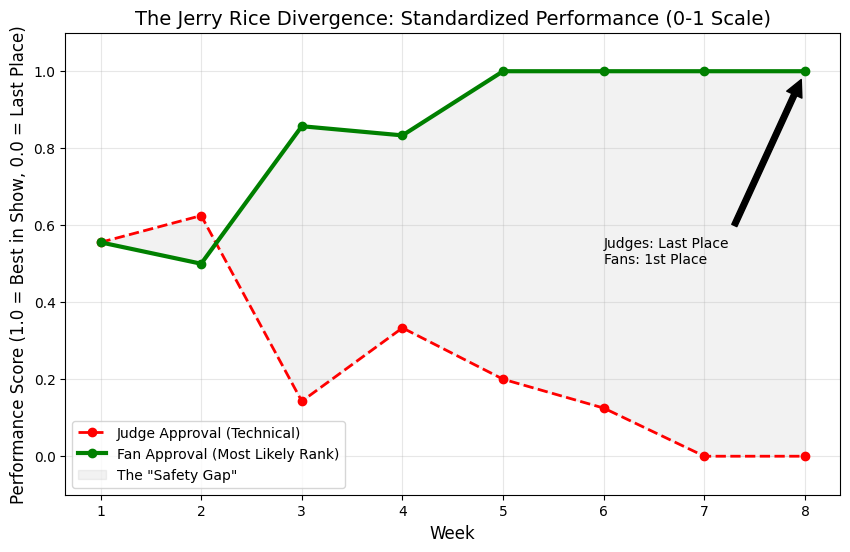

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('DWTS_Final_Model_With_Metadata.csv')

# Filter for Jerry Rice
jerry = df[df['Contestant'] == 'Jerry Rice'].copy()

# Calculate "N" (Number of contestants) for each week Jerry competed in
# We do this by checking the original dataframe for the count of contestants per week in Season 2
season_2_counts = df[df['Season'] == 2].groupby('Week')['Contestant'].count()

# Map the counts to Jerry's rows
jerry['Num_Contestants'] = jerry['Week'].map(season_2_counts)

# Calculate Standardized Scores (0 to 1 scale, where 1 is best)
# Formula: (N - Rank) / (N - 1)
# Use Most_Likely_Fan_Rank (Integer) instead of Expected (Float) to clearly show 1st Place predictions
jerry['Judge_Score_Std'] = (jerry['Num_Contestants'] - jerry['Judge_Rank']) / (jerry['Num_Contestants'] - 1)
jerry['Fan_Score_Std'] = (jerry['Num_Contestants'] - jerry['Distinct_Fan_Rank']) / (jerry['Num_Contestants'] - 1)

# Visualization
plt.figure(figsize=(10, 6))

# Plot Standardized Scores
plt.plot(jerry['Week'], jerry['Judge_Score_Std'], label='Judge Approval (Technical)', 
         marker='o', color='red', linestyle='--', linewidth=2)
plt.plot(jerry['Week'], jerry['Fan_Score_Std'], label='Fan Approval (Most Likely Rank)', 
         marker='o', color='green', linewidth=3)

# Add shading for the "Safety Gap"
plt.fill_between(jerry['Week'], jerry['Judge_Score_Std'], jerry['Fan_Score_Std'], 
                 color='gray', alpha=0.1, label='The "Safety Gap"')

plt.title("The Jerry Rice Divergence: Standardized Performance (0-1 Scale)", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Performance Score (1.0 = Best in Show, 0.0 = Last Place)", fontsize=12)
plt.ylim(-0.1, 1.1)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Annotate the final week
last_week = jerry.iloc[-1]
plt.annotate(f"Judges: Last Place\nFans: 1st Place", 
             xy=(last_week['Week'], last_week['Fan_Score_Std']), 
             xytext=(last_week['Week']-2, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

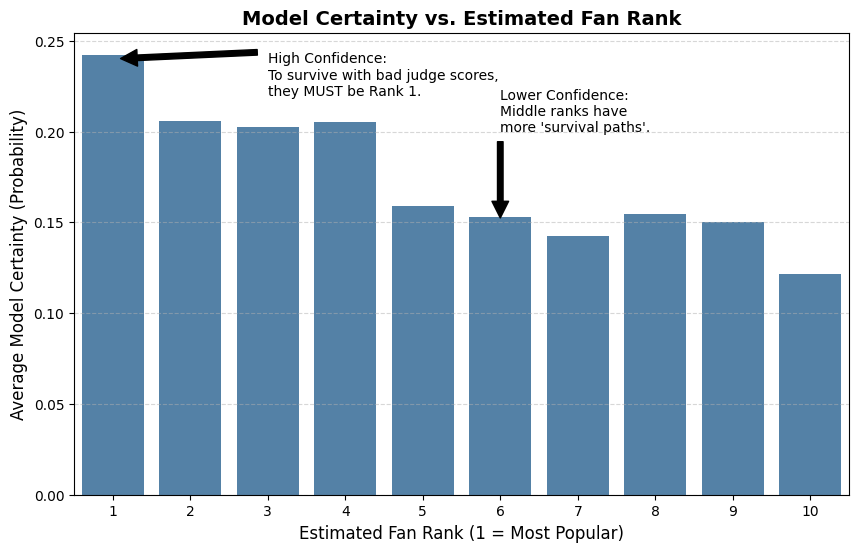

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
df = pd.read_csv('DWTS_Final_Model_With_Metadata.csv')

# 2. Group by Distinct Fan Rank to calculate average certainty
# We are asking: "Is the model more sure about Rank 1 than Rank 5?"
certainty_by_rank = df.groupby('Distinct_Fan_Rank')['Model_Certainty'].mean().reset_index()

# Filter to top 10 ranks for a cleaner graph (avoids noise from huge seasons)
certainty_by_rank = certainty_by_rank[certainty_by_rank['Distinct_Fan_Rank'] <= 10]

# 3. Create the Visualization
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Distinct_Fan_Rank', y='Model_Certainty', data=certainty_by_rank, color='steelblue')

# Styling
plt.title("Model Certainty vs. Estimated Fan Rank", fontsize=14, fontweight='bold')
plt.xlabel("Estimated Fan Rank (1 = Most Popular)", fontsize=12)
plt.ylabel("Average Model Certainty (Probability)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 4. Add Annotations to explain the "Why"
# Insight A: High certainty for Rank 1
plt.annotate("High Confidence:\nTo survive with bad judge scores,\nthey MUST be Rank 1.", 
             xy=(0, 0.24), xytext=(2, 0.22),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Insight B: Low certainty for Middle Ranks
plt.annotate("Lower Confidence:\nMiddle ranks have\nmore 'survival paths'.", 
             xy=(5, 0.15), xytext=(5, 0.20),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Save
plt.savefig('model_certainty_analysis.png', bbox_inches='tight')
plt.show()

--- Age vs. Fan Rank Analysis ---
Correlation Coefficient (r): 0.1864
P-value: 1.2757e-06
Result: Statistically Significant correlation.


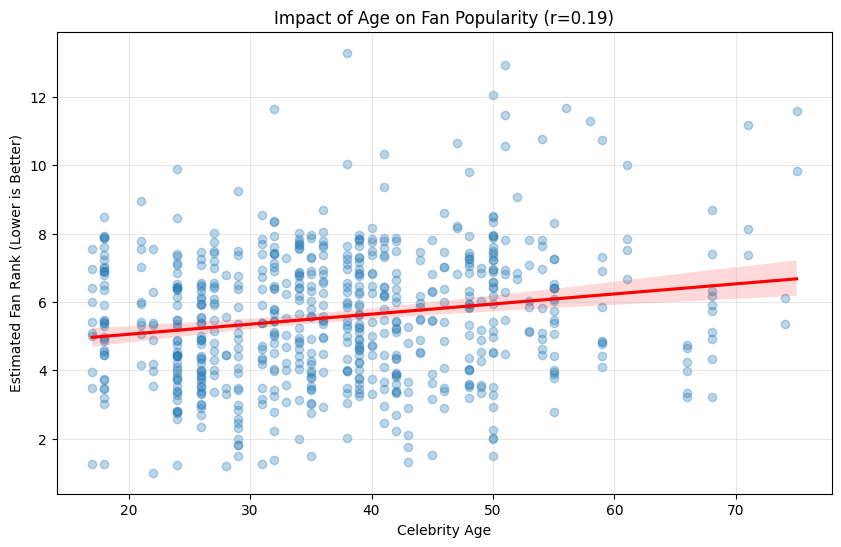


--- Athletes vs. Actors Analysis ---
                count      mean       std       min       25%       50%  \
Industry_Group                                                            
Actor           190.0  5.640075  2.060987  1.254839  4.116818  5.456649   
Athlete         104.0  5.175094  1.941251  1.186813  3.695486  5.001015   

                     75%        max  
Industry_Group                       
Actor           6.976202  12.936242  
Athlete         6.629721  11.687500  

T-Test Results:
T-statistic: -1.9210
P-value: 5.6012e-02
Result: No significant difference found between the groups.


C:\Users\sidan\AppData\Local\Temp\ipykernel_92380\4059540049.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Industry_Group', y='Expected_Fan_Rank', data=comparison_df, palette="Set2")


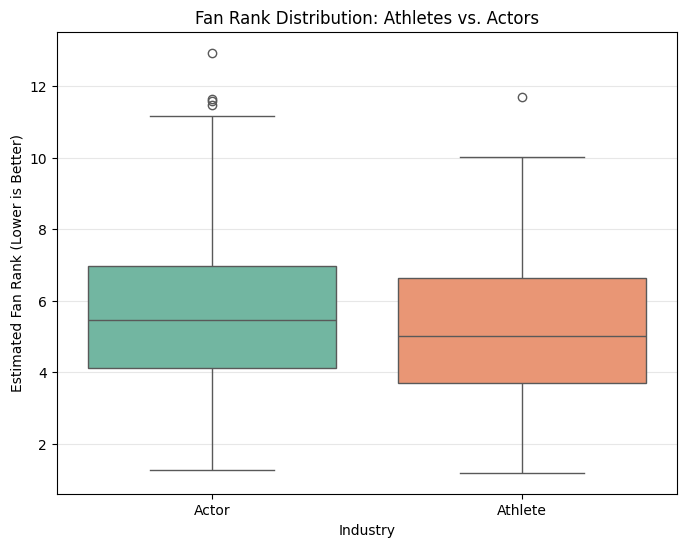

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Load the data
# We use the dataset created in the previous steps which contains the model results + metadata
df = pd.read_csv('DWTS_Final_Model_With_Metadata.csv')

# Clean up column names just in case
df.columns = df.columns.str.strip()

# --- PART A: AGE vs. FAN RANK ---
# Question: Does 'celebrity_age_during_season' correlate with 'Expected_Fan_Rank'?

# Drop rows where age or rank is missing
age_df = df.dropna(subset=['celebrity_age_during_season', 'Expected_Fan_Rank'])

# Calculate Pearson Correlation
correlation, p_value = stats.pearsonr(age_df['celebrity_age_during_season'], age_df['Expected_Fan_Rank'])

print(f"--- Age vs. Fan Rank Analysis ---")
print(f"Correlation Coefficient (r): {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("Result: Statistically Significant correlation.")
else:
    print("Result: No statistically significant correlation.")

# Visualization: Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='celebrity_age_during_season', y='Expected_Fan_Rank', data=age_df, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Impact of Age on Fan Popularity (r={correlation:.2f})')
plt.xlabel('Celebrity Age')
plt.ylabel('Estimated Fan Rank (Lower is Better)')
plt.grid(True, alpha=0.3)
plt.savefig('age_vs_fan_rank.png')
plt.show()


# --- PART B: ATHLETES vs. ACTORS ---
# Question: Do 'Athletes' have a better average Fan Rank than 'Actors'?

# 1. Standardize Industry Names (Handling "Actor/Actress" vs just "Actor", etc.)
# We'll look for strings containing "Athlete" or "Actor"
def normalize_industry(ind):
    ind = str(ind).lower()
    if 'athlete' in ind or 'sports' in ind or 'nfl' in ind or 'nba' in ind:
        return 'Athlete'
    elif 'actor' in ind or 'actress' in ind:
        return 'Actor'
    else:
        return 'Other'

df['Industry_Group'] = df['celebrity_industry'].apply(normalize_industry)

# Filter for just the two groups we care about
comparison_df = df[df['Industry_Group'].isin(['Athlete', 'Actor'])].dropna(subset=['Expected_Fan_Rank'])

# Descriptive Statistics
print("\n--- Athletes vs. Actors Analysis ---")
print(comparison_df.groupby('Industry_Group')['Expected_Fan_Rank'].describe())

# T-Test to check if the difference is significant
athletes = comparison_df[comparison_df['Industry_Group'] == 'Athlete']['Expected_Fan_Rank']
actors = comparison_df[comparison_df['Industry_Group'] == 'Actor']['Expected_Fan_Rank']

t_stat, p_val_ttest = stats.ttest_ind(athletes, actors, equal_var=False) # Welch's t-test

print(f"\nT-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val_ttest:.4e}")

if p_val_ttest < 0.05:
    winner = "Athletes" if athletes.mean() < actors.mean() else "Actors" # Lower rank is better
    print(f"Result: Significant difference found. {winner} perform better on average.")
else:
    print("Result: No significant difference found between the groups.")

# Visualization: Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Industry_Group', y='Expected_Fan_Rank', data=comparison_df, palette="Set2")
plt.title('Fan Rank Distribution: Athletes vs. Actors')
plt.ylabel('Estimated Fan Rank (Lower is Better)')
plt.xlabel('Industry')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig('athletes_vs_actors.png')
plt.show()

--- Top 5 Pro Partners by Average Placement (Min 3 Seasons) ---
         ballroom_partner  Avg_Placement  Season_Count
19            Derek Hough       2.941176            17
35         Julianne Hough       4.200000             5
17      Daniella Karagach       4.600000             5
45            Mark Ballas       5.190476            21
57  Valentin Chmerkovskiy       5.263158            19


C:\Users\sidan\AppData\Local\Temp\ipykernel_92380\2847233535.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Placement', y='ballroom_partner', data=top_pros, palette='viridis')
C:\Users\sidan\AppData\Local\Temp\ipykernel_92380\2847233535.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


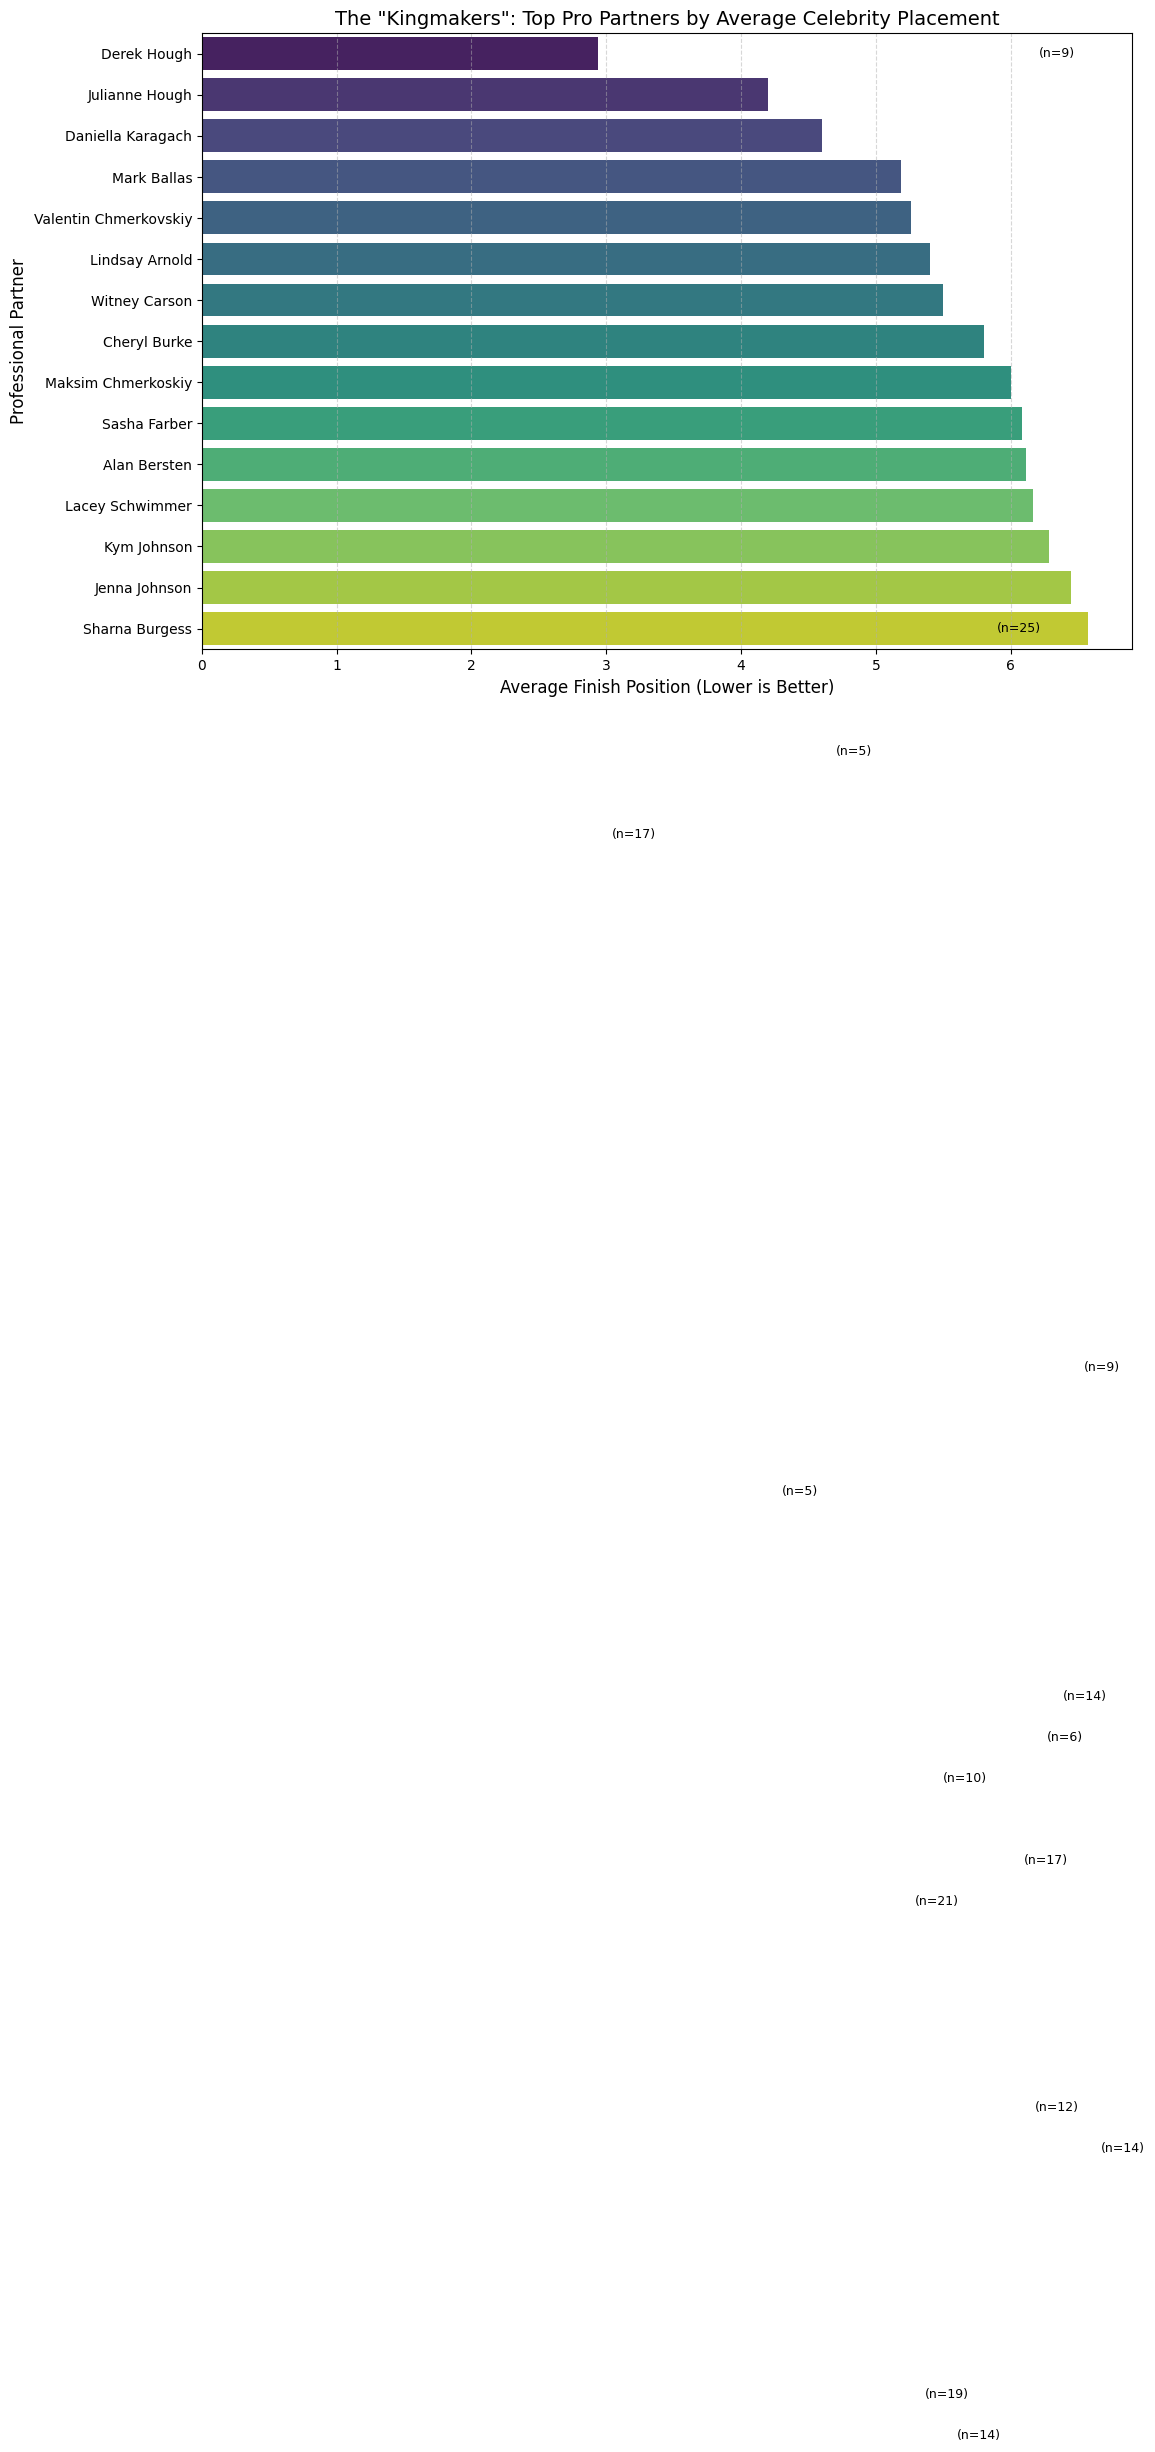

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Load the original dataset
df = pd.read_csv('2026_MCM_Problem_C_Data.csv')

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# 2. Extract numeric placement from the 'results' or 'placement' column
# The dataset has a 'placement' column which might contain strings like "1st Place", "2nd Place" or numbers.
# Or 'results' column like "Eliminated Week 4", "1st Place", etc.
# We need to standardize this to a numeric value where 1 = 1st Place.

def extract_placement(row):
    # Try 'placement' column first
    val = str(row.get('placement', ''))
    
    # Check for "Xst/nd/rd/th Place" pattern or just a number
    match = re.search(r'(\d+)', val)
    if match:
        return int(match.group(1))
    
    # If placement is empty or weird, try parsing 'results'
    res = str(row.get('results', ''))
    if "Place" in res:
        match_res = re.search(r'(\d+)', res)
        if match_res:
            return int(match_res.group(1))
            
    # For eliminated contestants, we can't easily assign a single "rank" number 
    # without knowing the total number of contestants that season.
    # However, if 'placement' exists in the source data as a number or rank string, use it.
    # If the user wants to use "placement" against partner, we assume the dataset has meaningful data there.
    # Let's inspect the 'placement' column in the loaded data to be sure.
    return None

df['numeric_placement'] = df.apply(extract_placement, axis=1)

# Filter out rows where we couldn't determine a numeric placement
df_clean = df.dropna(subset=['numeric_placement'])

# 3. Analyze Pro Partners
# Calculate average placement for each partner
# We also count how many seasons they've done to filter out one-time wonders
pro_stats = df_clean.groupby('ballroom_partner').agg(
    Avg_Placement=('numeric_placement', 'mean'),
    Season_Count=('season', 'count')
).reset_index()

# Filter for Pros with at least 3 seasons to identify consistent "Kingmakers"
pro_stats_filtered = pro_stats[pro_stats['Season_Count'] >= 3].sort_values('Avg_Placement')

# Get top 15 Pros (lowest average placement is best)
top_pros = pro_stats_filtered.head(15)

print("--- Top 5 Pro Partners by Average Placement (Min 3 Seasons) ---")
print(top_pros.head(5))

# 4. Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Avg_Placement', y='ballroom_partner', data=top_pros, palette='viridis')

plt.title('The "Kingmakers": Top Pro Partners by Average Celebrity Placement', fontsize=14)
plt.xlabel('Average Finish Position (Lower is Better)', fontsize=12)
plt.ylabel('Professional Partner', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add sample size annotation
for index, row in top_pros.iterrows():
    # Place text slightly to the right of the bar
    plt.text(row.Avg_Placement + 0.1, index, f"(n={row.Season_Count})", va='center', fontsize=9, color='black')

plt.tight_layout()
plt.savefig('pro_partner_effect.png')
plt.show()